# Run the codes and experiment on your own!

---

The problem covered in this notebook is quite a common one in Data Science. Suppose you work at a Bank as a Data Scientist or Analyst, and your task is to predict the **Credit Rating** of a customer (for a specific credit account) given the duration and amount of the credit, payment history of previous credits, as well as the employment status, gender and age of the customer. Check out the data in the attached file `CreditDefault.csv` to get a clearer picture.    

**Yes, you are absolutely right!** This is indeed a standard *Binary Classification* problem. Let's try out a few fun things on this dataset!

---

### Essential Libraries

Let us begin by importing the essential Python Libraries.

> NumPy : Library for Numeric Computations in Python  
> Pandas : Library for Data Acquisition and Preparation  
> Matplotlib : Low-level library for Data Visualization  
> Seaborn : Higher-level library for Data Visualization  

In [ ]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

---

## Setup : Import the Dataset

Dataset on Credit Rating : Attached file `CreditDefault.csv`     
You know by now what to do with any dataset after you import it.

In [ ]:
yr2020_data = pd.read_csv('pbp-2020.csv')
yr2020_data.head()

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,...,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards
0,2020122602,2020-12-26,2,9,44,LV,MIA,2,10,82,...,0,0,NaN,18,OPP,0,NaN,0,NaN,0
1,2020122602,2020-12-26,2,9,3,LV,MIA,3,19,73,...,0,0,LEFT GUARD,27,OPP,0,NaN,0,NaN,0
2,2020122500,2020-12-25,3,1,17,MIN,NO,3,9,67,...,0,0,NaN,33,OPP,0,NO,1,DEFENSIVE HOLDING,0
3,2020122500,2020-12-25,3,1,12,MIN,NO,1,10,82,...,0,0,NaN,18,OPP,1,NO,1,DEFENSIVE PASS INTERFERENCE,17
4,2020122500,2020-12-25,3,1,6,MIN,NO,1,1,99,...,0,0,LEFT GUARD,1,OPP,0,NaN,0,NaN,0


In [ ]:
creditData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Duration   1000 non-null   int64 
 1   Amount     1000 non-null   int64 
 2   History    1000 non-null   object
 3   EmpStatus  1000 non-null   object
 4   Gender     1000 non-null   object
 5   Age        1000 non-null   int64 
 6   Rating     1000 non-null   object
dtypes: int64(3), object(4)
memory usage: 54.8+ KB


Let's list down all our observations from the super-quick glance of the dataset, as above.
* There are `7` variables/features/columns and `1000` observations/samples/rows in the dataset.    
* The response variable seems to be `Rating`, while the remaining 6 are most likely predictors.     
* There are `3` variables identified as `int64` by default, and it seems they are indeed Numeric.     
* There are `4` variables identified as `object` by default, and they are most likely Categorical.      
* None of the variables/features seem to have any missing value (have to check again, carefully).

---
## Exploratory Data Analysis

Let us start by exploring the response variable `Rating`, the one we are supposed to predict at the end of the day.

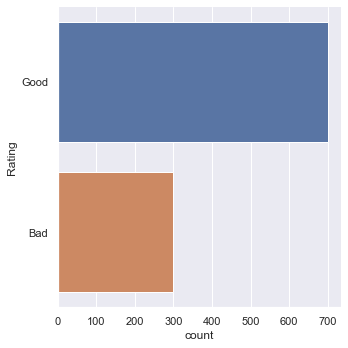

In [ ]:
sb.catplot(y = 'Rating', data = creditData, kind = "count")

In [ ]:
countG, countB = creditData['Rating'].value_counts()
print("Ratio of classes is Good : Bad = ", countG, ":", countB)

Ratio of classes is Good : Bad =  700 : 300


Alright. We see a large class imbalance in the Response variable.     
Unless we fix this, Classification models may face some problems.    

Anyway, let's go ahead as it is, for the time being. May be later.

Quickly check out the Numeric and Categorical predictors separately, as the standard functions behave differently for them.

In [ ]:
# Numeric Predictors
creditData[['Duration','Amount','Age']].describe()

,Duration,Amount,Age
count,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,35.546000
std,12.058814,2822.736876,11.375469
min,4.000000,250.000000,19.000000
25%,12.000000,1365.500000,27.000000
50%,18.000000,2319.500000,33.000000
75%,24.000000,3972.250000,42.000000
max,72.000000,18424.000000,75.000000


In [ ]:
# Categorical Predictors
creditData[['History','EmpStatus','Gender']].describe()

,History,EmpStatus,Gender
count,1000,1000,1000
unique,5,5,2
top,PaidDuly,lessFour,Male
freq,530,339,690


Ok. Not much yet. We just know that the variables and their values/ranges kind of make sense.   
* Duration seems to be in Months, as the mean is around 20, while the min and max are 4 and 72.    
* Amount seems to be in the currency amount (probably Dollars), guessing from the distribution.      
* Age seems to be logical and in the correct scale, with min = 19 (legal age > 18?) and max = 75.    
* History has 5 levels, with the customers paying previous credits duly seem to be the majority (530).     
* Employment Status seems to be in number of years; 5 levels, with majority (339) less than 4 years.      
* Gender has 2 levels, most likely Male and Female, with the majority (690) being Male customers.      

If you need to know more about each variable, this is a good time to ask the person who actually collected the data or put together the dataset. You may also ask them about which variables they think are more important, as a part of "domain knowledge". However, we will work *blindly* on this dataset, as of now.

Time for some visualizations to check the distribution of the predictor variables, one by one, for both Numeric and Categorical predictors. However, we will not just do it sequentially as they appear in the dataset as columms. We know better -- there are 2 predictors corresponding to the specific credit, while the other 4 predictors correspond to the specific customer. Let's check the predictors in that order to make more sense of our dataset, and gain better insights.

### Predictors corresponding to the Credit

<AxesSubplot:xlabel='Amount', ylabel='Count'>

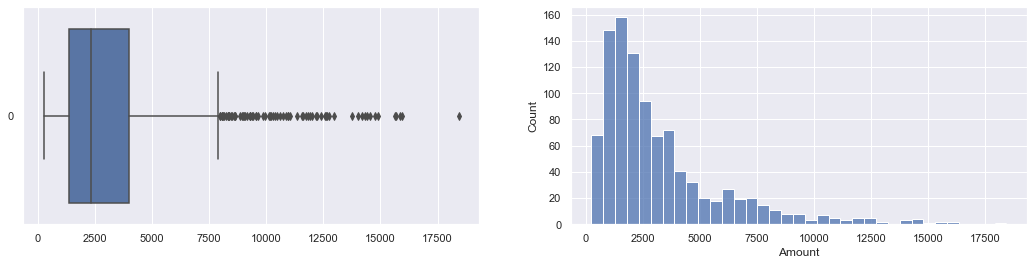

In [ ]:
# Amount of the Credit
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(data = creditData['Amount'], orient = "h", ax = axes[0])
sb.histplot(data = creditData['Amount'], ax = axes[1])

*What can you observe from the distribution of Amount?* 
- Try to write a few points based on the distribution above.
- Try to talk to your friend(s) and see what the others think.

<AxesSubplot:xlabel='Duration', ylabel='Count'>

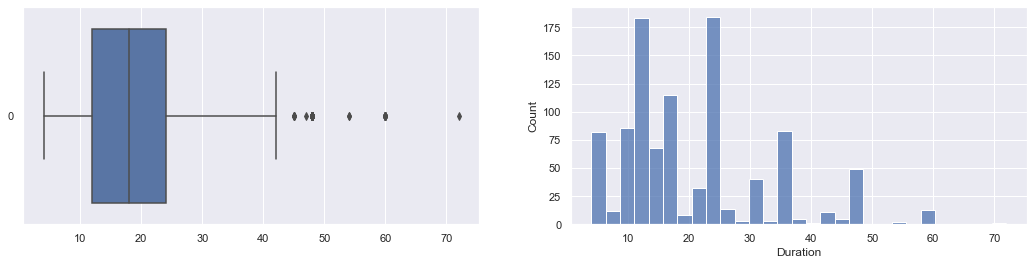

In [ ]:
# Duration of the Credit
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(data = creditData['Duration'], orient = "h", ax = axes[0])
sb.histplot(data = creditData['Duration'], ax = axes[1])

*What can you observe from the distribution of Duration?* 
- Try to write a few points based on the distribution above.
- Try to talk to your friend(s) and see what the others think.

### Predictors corresponding to the Customer

<AxesSubplot:xlabel='Duration', ylabel='Count'>

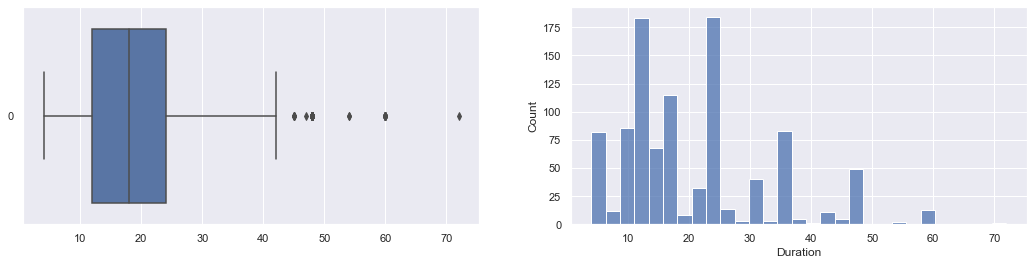

In [ ]:
# Age of the Customer
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(data = creditData['Duration'], orient = "h", ax = axes[0])
sb.histplot(data = creditData['Duration'], ax = axes[1])

*What can you observe from the distribution of Age?* 
- Try to write a few points based on the distribution above.
- Try to talk to your friend(s) and see what the others think.

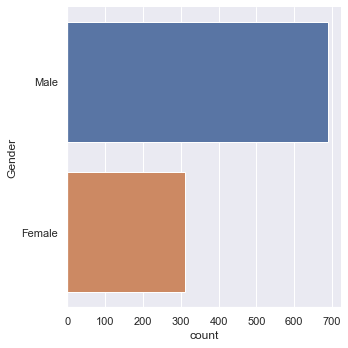

In [ ]:
# Gender of the Customer
sb.catplot(y = 'Gender', data = creditData, kind = "count")

*What can you observe from the distribution of Gender?* 
- Try to write a few points based on the distribution above.
- Try to talk to your friend(s) and see what the others think.

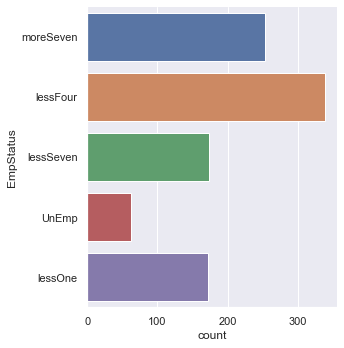

In [ ]:
# Employment Status of the Customer
sb.catplot(y = 'EmpStatus', data = creditData, kind = "count")

*What can you observe from the distribution of Employment Status?* 
- Try to write a few points based on the distribution above.
- Try to talk to your friend(s) and see what the others think.

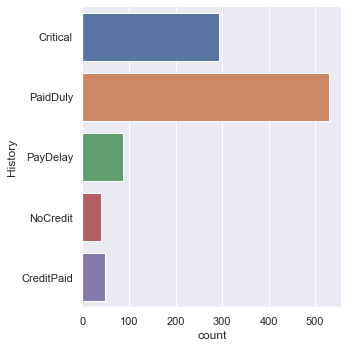

In [ ]:
# History of Payment
sb.catplot(y = 'History', data = creditData, kind = "count")

*What can you observe from the distribution of History?* 
- Try to write a few points based on the distribution above.
- Try to talk to your friend(s) and see what the others think.

### Relationship with Rating

Ok. Now that we understand the individual predictors better, let's find out what causes Good or Bad Rating. Is it the credit Amount or Duration in general, or does the Rating actually depend on the features related to the customer? Check mutual relationships to find out *potential* effect of predictors on Rating.

<AxesSubplot:xlabel='Amount', ylabel='Rating'>

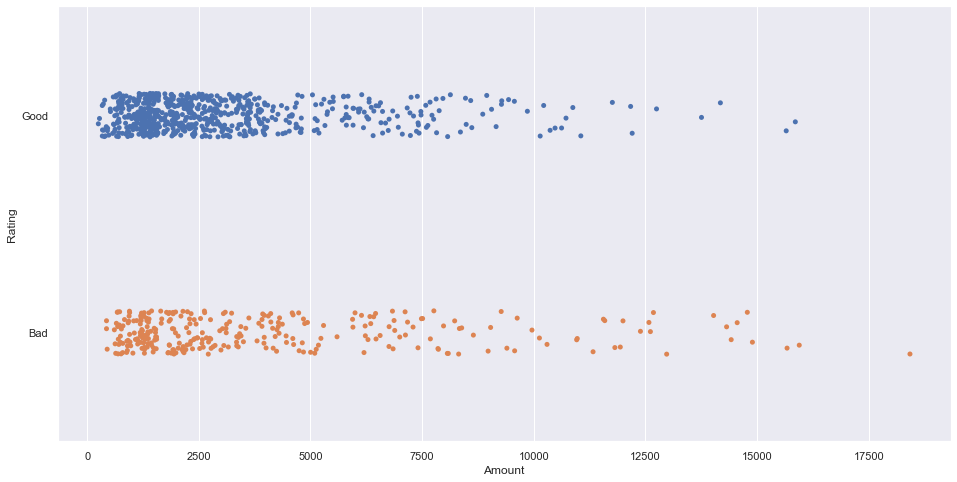

In [ ]:
# Rating vs Amount
f = plt.figure(figsize=(16, 8))
sb.stripplot(x = 'Amount', y = 'Rating', data = creditData)

*Do you think credit Amount affects Rating directly?*
- Try to write a few points based on the plots you tried out.
- Try to talk to your friend(s) and see what the others think.

<AxesSubplot:xlabel='Duration', ylabel='Rating'>

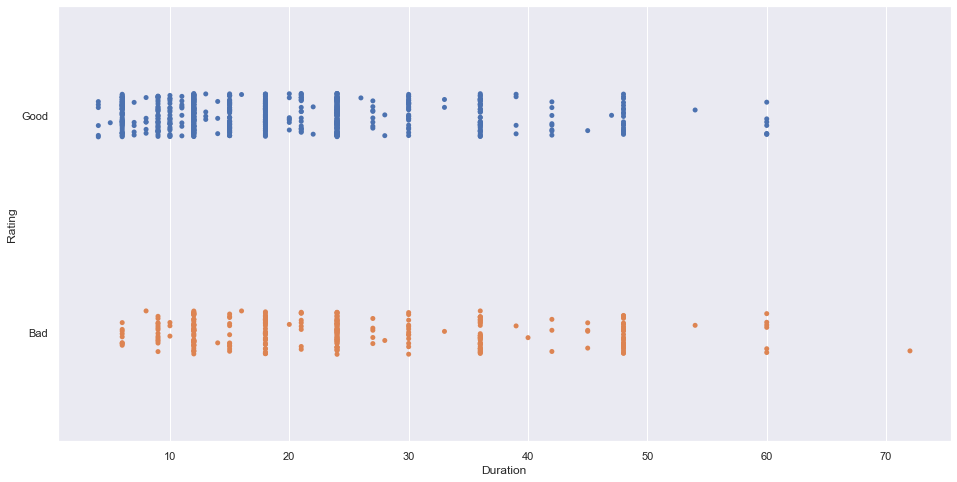

In [ ]:
# Rating vs Duration
f = plt.figure(figsize=(16, 8))
sb.stripplot(x = 'Duration', y = 'Rating', data = creditData)

*Do you think credit Duration affects Rating directly?*
- Try to write a few points based on the plots you tried out.
- Try to talk to your friend(s) and see what the others think.

<AxesSubplot:xlabel='Age', ylabel='Rating'>

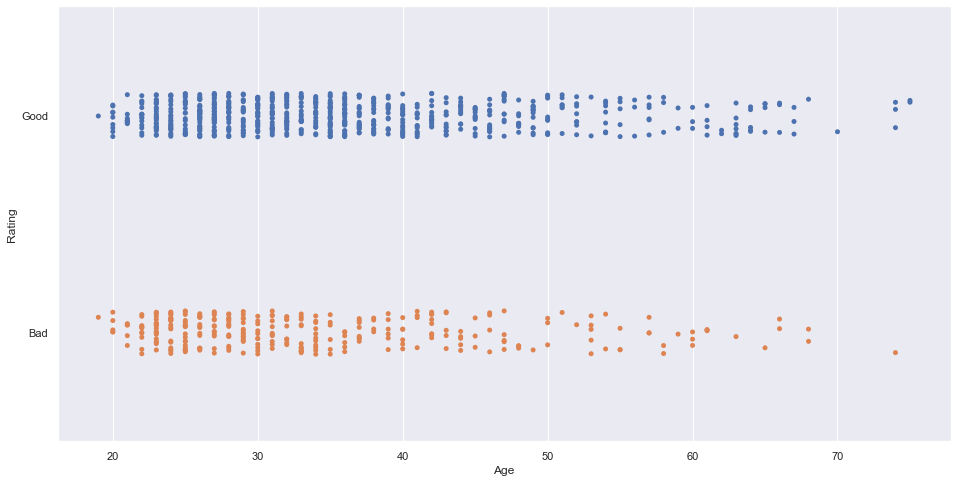

In [ ]:
# Rating vs Age
f = plt.figure(figsize=(16, 8))
sb.stripplot(x = 'Age', y = 'Rating', data = creditData)

*Do you think credit Rating depends on the Age of customer?*
- Try to write a few points based on the plots you tried out.
- Try to talk to your friend(s) and see what the others think.

<AxesSubplot:xlabel='Gender', ylabel='Rating'>

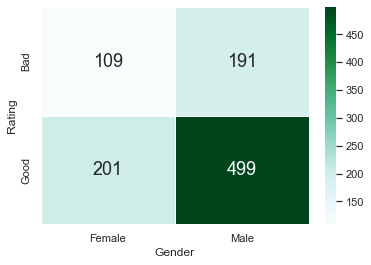

In [ ]:
# Rating vs Gender
f = plt.figure(figsize=(6, 4))
sb.heatmap(creditData.groupby(['Rating', 'Gender']).size().unstack(), 
           linewidths = 1, annot = True, fmt = 'g', annot_kws = {"size": 18}, cmap = "BuGn")

*Do you think credit Rating depends on the Gender of customer?*
- Try to write a few points based on the plots you tried out.
- Try to talk to your friend(s) and see what the others think.

<AxesSubplot:xlabel='EmpStatus', ylabel='Rating'>

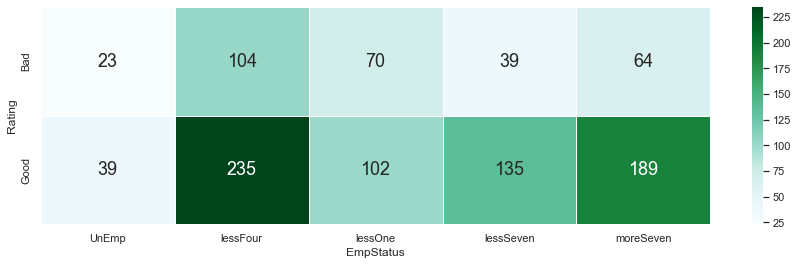

In [ ]:
# Rating vs Employment Status
f = plt.figure(figsize=(15, 4))
sb.heatmap(creditData.groupby(['Rating', 'EmpStatus']).size().unstack(), 
           linewidths = 1, annot = True, fmt = 'g', annot_kws = {"size": 18}, cmap = "BuGn")

*Do you think credit Rating depends on the Employment Status of customer?*
- Try to write a few points based on the plots you tried out.
- Try to talk to your friend(s) and see what the others think.

<AxesSubplot:xlabel='History', ylabel='Rating'>

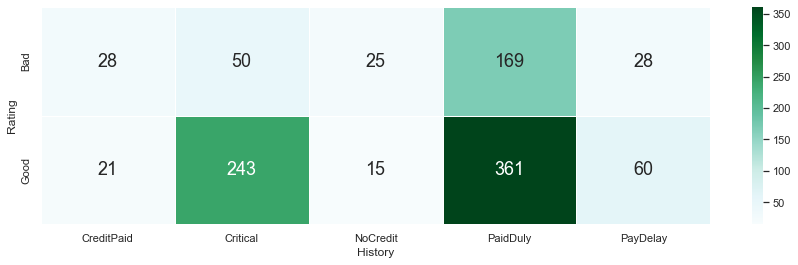

In [ ]:
# Rating vs History of Payment
f = plt.figure(figsize=(15, 4))
sb.heatmap(creditData.groupby(['Rating', 'History']).size().unstack(), 
           linewidths = 1, annot = True, fmt = 'g', annot_kws = {"size": 18}, cmap = "BuGn")

*Do you think credit Rating depends on the payment History of customer?*
- Try to write a few points based on the plots you tried out.
- Try to talk to your friend(s) and see what the others think.

### Complex Relationships with Rating

Let's try to explore slightly more complex bi-variate relationships of predictors with Rating, and see if we can observe something more interesting.

<AxesSubplot:xlabel='Duration', ylabel='Amount'>

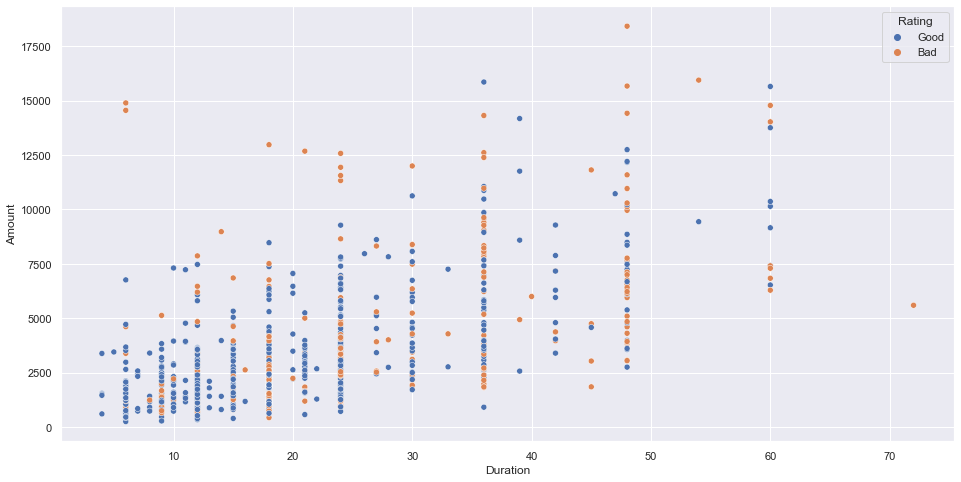

In [ ]:
# Rating vs Amount and Duration
f = plt.figure(figsize=(16, 8))
sb.scatterplot(x = 'Duration', y = 'Amount', hue = 'Rating', data = creditData)

*Anything more interesting based on the plot above?* 
- Write your comments based on the plot you tried out above.
- Try out other similar Numeric-vs-Numeric plots with Rating.

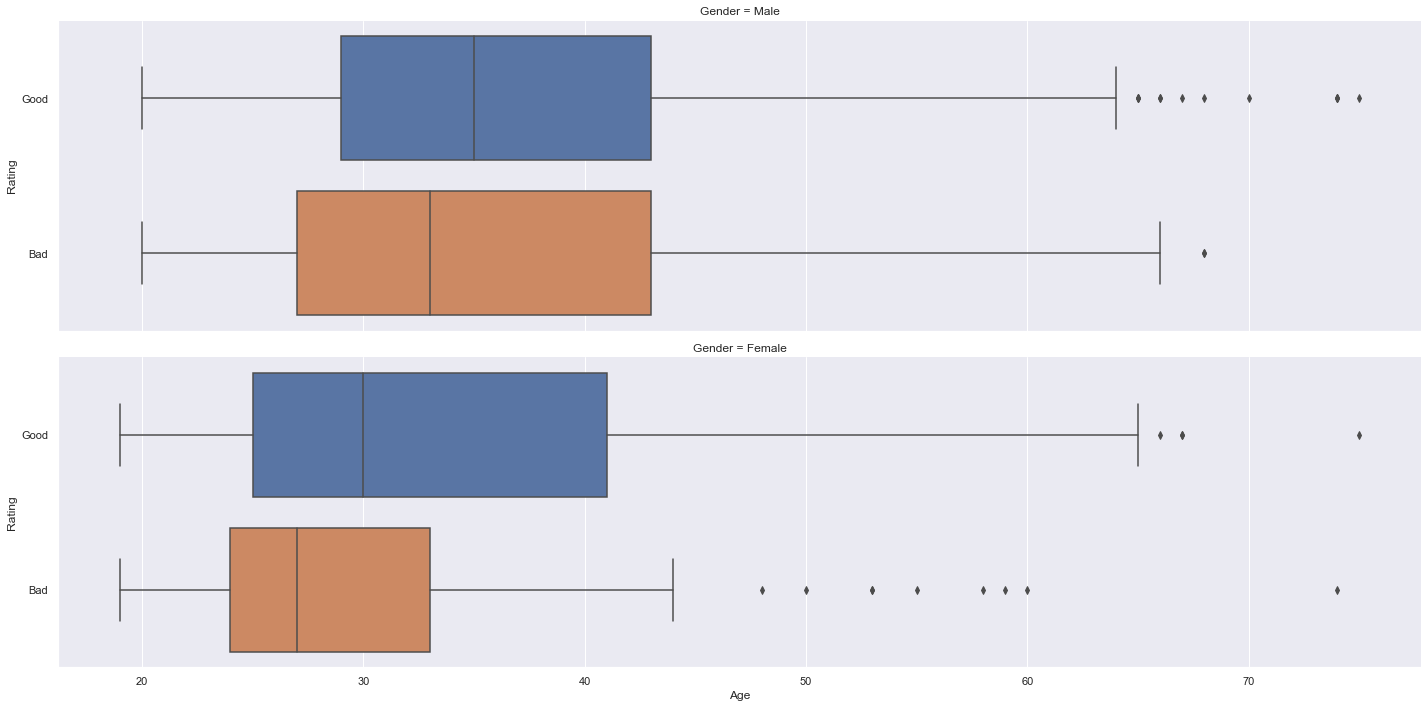

In [ ]:
# Rating vs Age and Gender
sb.catplot(x = 'Age', y = 'Rating', row = 'Gender', data = creditData, kind = 'box', aspect = 4)

*Anything more interesting based on the plot above?* 
- Write your comments based on the plot you tried out above.
- Try out other similar Numeric-vs-Categorical plots with Rating.

Once you are satisfied with basic EDA, proceed to building the actual Classification Model on the dataset, as follows. Note that after building the model, fitting it properly on the train data, and getting predictions out of it, you will again need to come back to EDA to connect the observations and comments you made initially with what you obtain from the model. Thus, EDA is not just a routine check; it is one of the most crucial stages of Data Science. Do pay attention!

---

## Creating a Model for Rating : Attempt 1

We will start with what we already know -- a multi-variate Classification Tree with all 6 predictors and Rating as response.     

**Note** : `DecisionTreeClassifier` in `sklearn` does not handle categorical variables directly as a part of the current implementation. Thus, you will need to encode the levels of a categorical variable as integers. However, as the categorical variables may not be *ordinal*, you can't enforce an order with integer encoding (e.g., you can't encode Male and Female as 0 and 1 in Gender, as it enforces an implicit order). One way to encode nominal (unordered) categorical variables by integers is `OneHotEncoding`, and you can use it from `sklearn` preprocessing module. Do check out more about this encoding.

In [ ]:
# Import the encoder from sklearn
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

# OneHotEncoding of categorical predictors (not the response)
creditData_cat = creditData[['Gender','EmpStatus','History']]
ohe.fit(creditData_cat)
creditData_cat_ohe = pd.DataFrame(ohe.transform(creditData_cat).toarray(), 
                                  columns=ohe.get_feature_names(creditData_cat.columns))

# Check the encoded variables
creditData_cat_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gender_Female        1000 non-null   float64
 1   Gender_Male          1000 non-null   float64
 2   EmpStatus_UnEmp      1000 non-null   float64
 3   EmpStatus_lessFour   1000 non-null   float64
 4   EmpStatus_lessOne    1000 non-null   float64
 5   EmpStatus_lessSeven  1000 non-null   float64
 6   EmpStatus_moreSeven  1000 non-null   float64
 7   History_CreditPaid   1000 non-null   float64
 8   History_Critical     1000 non-null   float64
 9   History_NoCredit     1000 non-null   float64
 10  History_PaidDuly     1000 non-null   float64
 11  History_PayDelay     1000 non-null   float64
dtypes: float64(12)
memory usage: 93.9 KB


In [ ]:
# Combining Numeric features with the OHE Categorical features
creditData_num = creditData[['Amount','Duration','Age']]
creditData_res = creditData['Rating']
creditData_ohe = pd.concat([creditData_num, creditData_cat_ohe, creditData_res], 
                           sort = False, axis = 1).reindex(index=creditData_num.index)

# Check the final dataframe
creditData_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Amount               1000 non-null   int64  
 1   Duration             1000 non-null   int64  
 2   Age                  1000 non-null   int64  
 3   Gender_Female        1000 non-null   float64
 4   Gender_Male          1000 non-null   float64
 5   EmpStatus_UnEmp      1000 non-null   float64
 6   EmpStatus_lessFour   1000 non-null   float64
 7   EmpStatus_lessOne    1000 non-null   float64
 8   EmpStatus_lessSeven  1000 non-null   float64
 9   EmpStatus_moreSeven  1000 non-null   float64
 10  History_CreditPaid   1000 non-null   float64
 11  History_Critical     1000 non-null   float64
 12  History_NoCredit     1000 non-null   float64
 13  History_PaidDuly     1000 non-null   float64
 14  History_PayDelay     1000 non-null   float64
 15  Rating               1000 non-null   ob

### Create and Fit the Model

Finally, after the encoding is done, we can create and fit the `DecisionTreeClassifier` model on the dataset.

[Text(681.5571428571428, 1174.1760000000002, 'Duration <= 34.5\ngini = 0.421\nsamples = 700\nvalue = [211, 489]\nclass = Good'),
 Text(382.62857142857143, 913.248, 'History_Critical <= 0.5\ngini = 0.385\nsamples = 585\nvalue = [152, 433]\nclass = Good'),
 Text(191.31428571428572, 652.3200000000002, 'History_CreditPaid <= 0.5\ngini = 0.429\nsamples = 410\nvalue = [128, 282]\nclass = Good'),
 Text(95.65714285714286, 391.39200000000005, 'Amount <= 8630.5\ngini = 0.414\nsamples = 386\nvalue = [113, 273]\nclass = Good'),
 Text(47.82857142857143, 130.46400000000017, 'gini = 0.407\nsamples = 380\nvalue = [108, 272]\nclass = Good'),
 Text(143.4857142857143, 130.46400000000017, 'gini = 0.278\nsamples = 6\nvalue = [5, 1]\nclass = Bad'),
 Text(286.9714285714286, 391.39200000000005, 'Gender_Female <= 0.5\ngini = 0.469\nsamples = 24\nvalue = [15, 9]\nclass = Bad'),
 Text(239.14285714285714, 130.46400000000017, 'gini = 0.498\nsamples = 15\nvalue = [7, 8]\nclass = Good'),
 Text(334.8, 130.46400000000

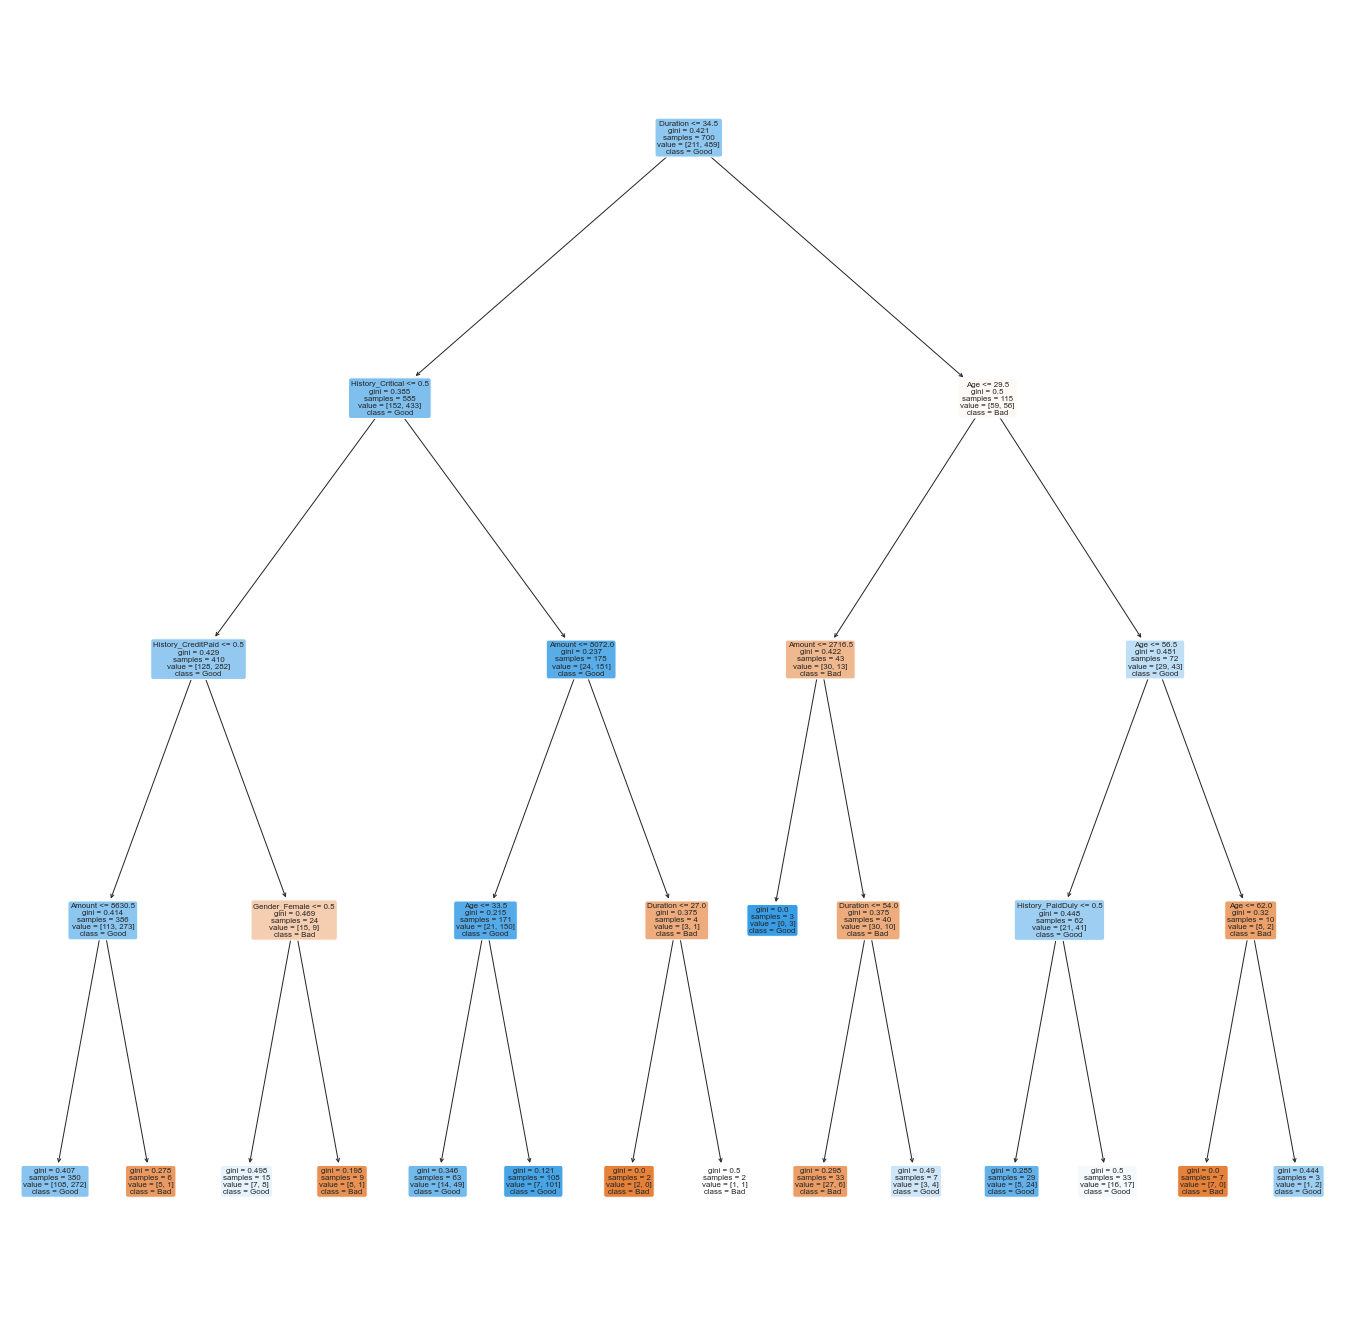

In [ ]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

# Extract Response and Predictors
y = pd.DataFrame(creditData_ohe['Rating'])
X = pd.DataFrame(creditData_ohe.drop('Rating', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # change max_depth to experiment
dectree.fit(X_train, y_train)                    # train the decision tree model

# Plot the trained Decision Tree
f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["Bad","Good"])

### Check the accuracy of the Model

Print the Classification Accuracy and all other Accuracy Measures from the Confusion Matrix.  

| Confusion Matrix  |       |        |        |      
| :---              | :---: | :----: | :----: |         
| Actual Negative   |  (0)  |   TN   |   FP   |             
| Actual Positive   |  (1)  |   FN   |   TP   |       
|                   |       |   (0)   |   (1)   |       
|                   |       | Predicted Negative    |   Predicted Postitive  |     


* `TPR = TP / (TP + FN)` : True Positive Rate = True Positives / All Positives    
* `TNR = TN / (TN + FP)` : True Negative Rate = True Negatives / All Negatives    

* `FPR = FP / (TN + FP)` : False Positive Rate = False Positives / All Negatives 
* `FNR = FN / (TP + FN)` : False Negative Rate = False Negatives / All Positives 

Train Data
Accuracy  :	 0.7571428571428571

TPR Train :	 0.9815950920245399
TNR Train :	 0.23696682464454977

FPR Train :	 0.7630331753554502
FNR Train :	 0.018404907975460124


<AxesSubplot:>

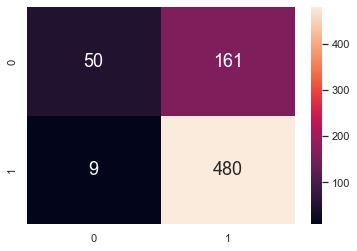

In [ ]:
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.72

TPR Test :	 0.966824644549763
TNR Test :	 0.1348314606741573

FPR Test :	 0.8651685393258427
FNR Test :	 0.03317535545023697


<AxesSubplot:>

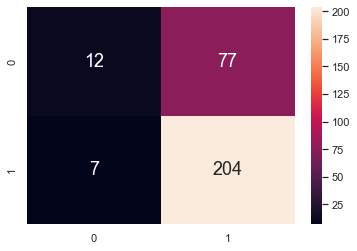

In [ ]:
# Import the required metric from sklearn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_test_pred = dectree.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", dectree.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

**Important** : Note the huge imbalance in the *False Positives* and *False Negatives* in the confusion matrix. *False Positives* are much higher in number than *False Negatives* in both Train and Test data. This is not surprising -- actually, this is a direct effect of the large `Good` vs `Bad` class imbalance in the response variable `Rating`. As `Rating = Good` was more likely in the data, *False Positives* are more likely too. Let's see if we can fix it.

---

## Create a Model for Rating : Attempt 2

Let's refine the previous model by balancing the classes of the response `Rating` in the training data. Keeping the OneHotEncoding same as before.

In [ ]:
# Upsample Bad to match Good
from sklearn.utils import resample

creditBad = creditData_ohe[creditData_ohe.Rating == 'Bad']
creditGood = creditData_ohe[creditData_ohe.Rating == 'Good']
 
# Upsample the Bad samples
creditBad_up = resample(creditBad, 
                        replace=True,                     # sample with replacement
                        n_samples=creditGood.shape[0])    # to match number of Good
 
# Combine the two classes back after upsampling
creditData_ohe_up = pd.concat([creditGood, creditBad_up])
 
# Check the ratio of the classes
creditData_ohe_up['Rating'].value_counts()

Good    700
Bad     700
Name: Rating, dtype: int64

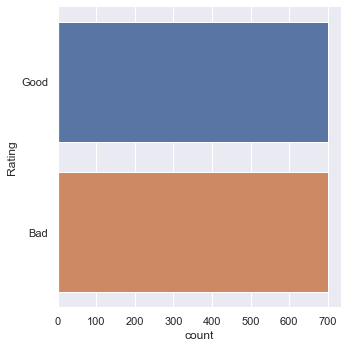

In [ ]:
# Quick plot to check the balanced classes visually
sb.catplot(y = 'Rating', data = creditData_ohe_up, kind = "count")

In [ ]:
# Confirm that the OHE is still in place
# and that the samples have now increased
creditData_ohe_up.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1400 entries, 0 to 757
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Amount               1400 non-null   int64  
 1   Duration             1400 non-null   int64  
 2   Age                  1400 non-null   int64  
 3   Gender_Female        1400 non-null   float64
 4   Gender_Male          1400 non-null   float64
 5   EmpStatus_UnEmp      1400 non-null   float64
 6   EmpStatus_lessFour   1400 non-null   float64
 7   EmpStatus_lessOne    1400 non-null   float64
 8   EmpStatus_lessSeven  1400 non-null   float64
 9   EmpStatus_moreSeven  1400 non-null   float64
 10  History_CreditPaid   1400 non-null   float64
 11  History_Critical     1400 non-null   float64
 12  History_NoCredit     1400 non-null   float64
 13  History_PaidDuly     1400 non-null   float64
 14  History_PayDelay     1400 non-null   float64
 15  Rating               1400 non-null   ob

### Create and Fit the Model

Finally, after the encoding and upsampling is done, we can create and fit the `DecisionTreeClassifier` model on the dataset.

[Text(697.5, 1174.1760000000002, 'Duration <= 34.5\ngini = 0.5\nsamples = 980\nvalue = [502, 478]\nclass = Bad'),
 Text(418.50000000000006, 913.248, 'History_Critical <= 0.5\ngini = 0.494\nsamples = 760\nvalue = [340, 420]\nclass = Good'),
 Text(223.20000000000002, 652.3200000000002, 'History_CreditPaid <= 0.5\ngini = 0.499\nsamples = 566\nvalue = [292, 274]\nclass = Bad'),
 Text(111.60000000000001, 391.39200000000005, 'Age <= 25.5\ngini = 0.5\nsamples = 505\nvalue = [245, 260]\nclass = Good'),
 Text(55.800000000000004, 130.46400000000017, 'gini = 0.469\nsamples = 141\nvalue = [88, 53]\nclass = Bad'),
 Text(167.4, 130.46400000000017, 'gini = 0.491\nsamples = 364\nvalue = [157, 207]\nclass = Good'),
 Text(334.8, 391.39200000000005, 'Age <= 23.5\ngini = 0.354\nsamples = 61\nvalue = [47, 14]\nclass = Bad'),
 Text(279.0, 130.46400000000017, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]\nclass = Good'),
 Text(390.6, 130.46400000000017, 'gini = 0.307\nsamples = 58\nvalue = [47, 11]\nclass = Bad')

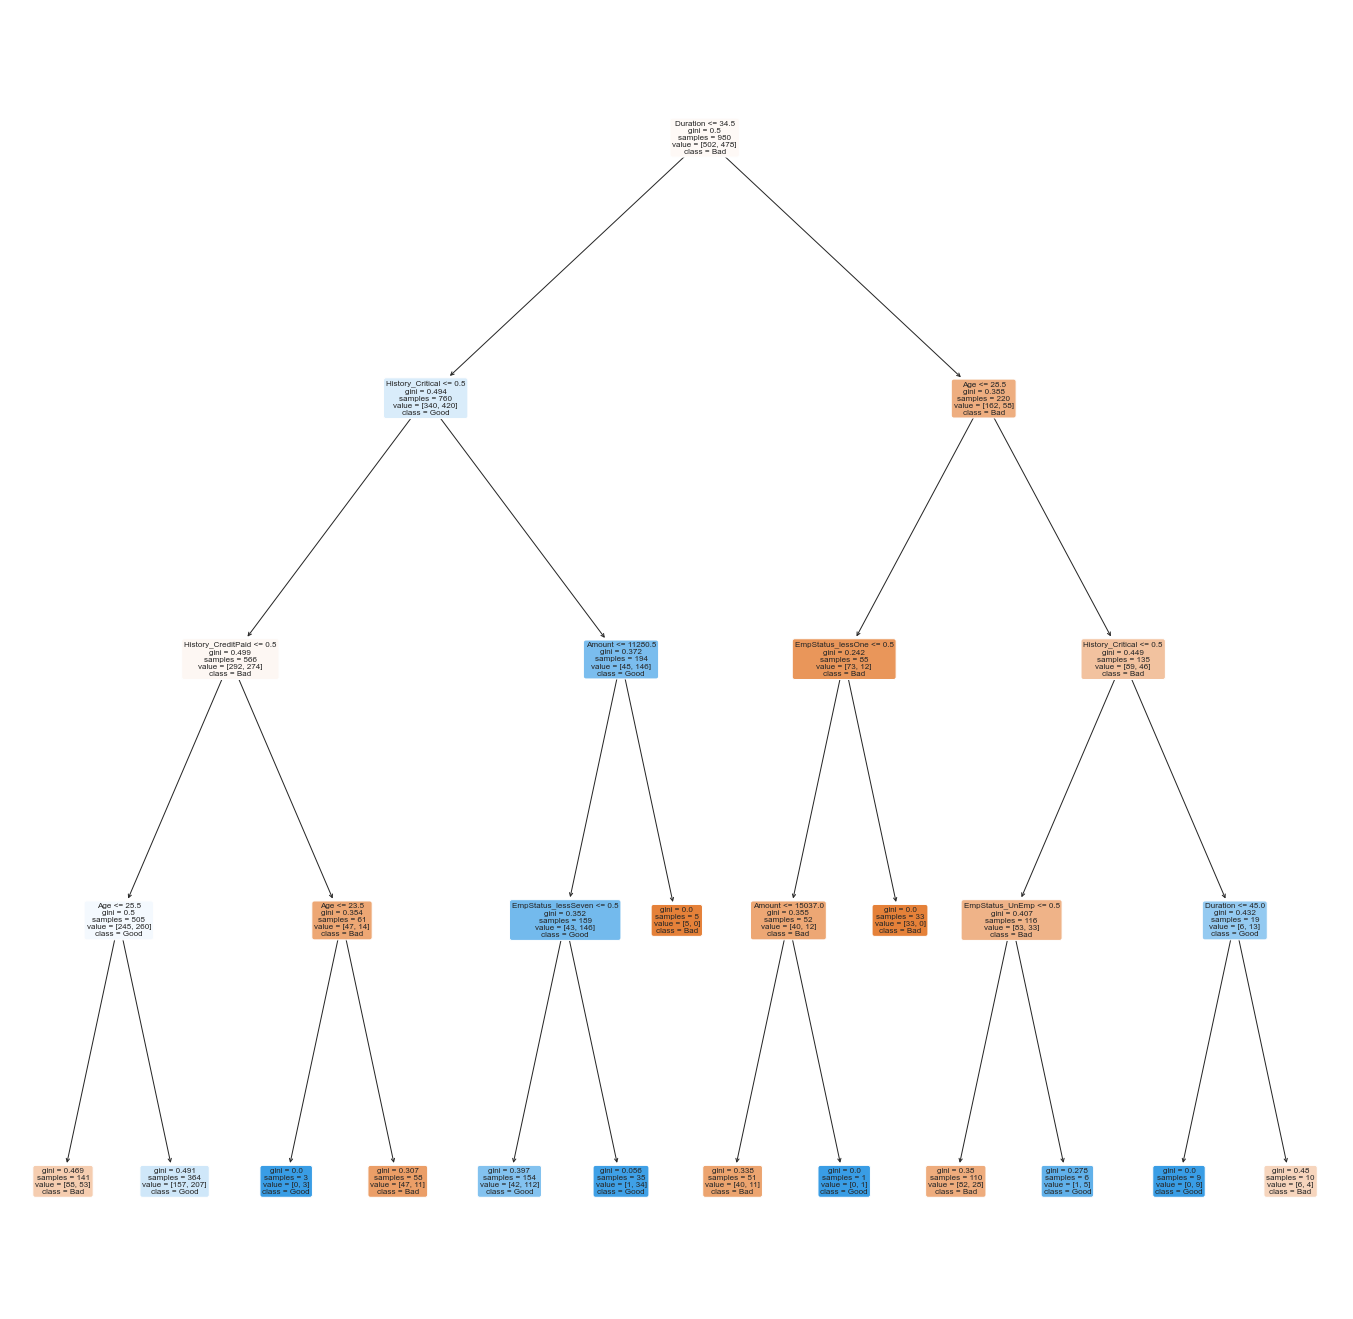

In [ ]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

# Extract Response and Predictors
y = pd.DataFrame(creditData_ohe_up['Rating'])
X = pd.DataFrame(creditData_ohe_up.drop('Rating', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # change max_depth to experiment
dectree.fit(X_train, y_train)                    # train the decision tree model

# Plot the trained Decision Tree
f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["Bad","Good"])

### Check the accuracy of the Model

Print the Classification Accuracy and all other Accuracy Measures from the Confusion Matrix.  

| Confusion Matrix  |       |        |        |      
| :---              | :---: | :----: | :----: |         
| Actual Negative   |  (0)  |   TN   |   FP   |             
| Actual Positive   |  (1)  |   FN   |   TP   |       
|                   |       |   (0)   |   (1)   |       
|                   |       | Predicted Negative    |   Predicted Postitive  |     


* `TPR = TP / (TP + FN)` : True Positive Rate = True Positives / All Positives    
* `TNR = TN / (TN + FP)` : True Negative Rate = True Negatives / All Negatives    

* `FPR = FP / (TN + FP)` : False Positive Rate = False Positives / All Negatives 
* `FNR = FN / (TP + FN)` : False Negative Rate = False Negatives / All Positives 

Train Data
Accuracy  :	 0.6857142857142857

TPR Train :	 0.7761506276150628
TNR Train :	 0.599601593625498

FPR Train :	 0.40039840637450197
FNR Train :	 0.22384937238493724


<AxesSubplot:>

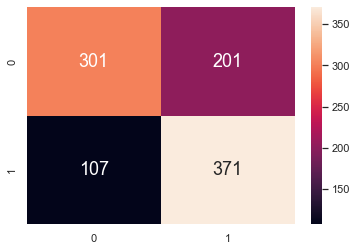

In [ ]:
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.6714285714285714

TPR Test :	 0.7927927927927928
TNR Test :	 0.5353535353535354

FPR Test :	 0.46464646464646464
FNR Test :	 0.2072072072072072


<AxesSubplot:>

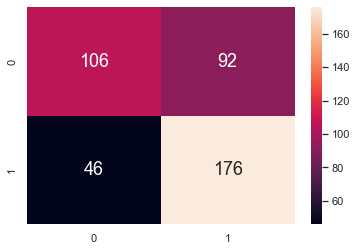

In [ ]:
# Import the required metric from sklearn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_test_pred = dectree.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", dectree.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Voila! The false positives and false negatives seem more balanced now. Good job with the upsampling. As always, there is room for improvement.

---
## Create a Model for Rating : Attempt 3

It is quite obvious that the Decision Tree is not doing too well, even after upsampling and encoding. It is time for us to move on to some other classifiers. Let's try another tree based classifier -- `RandomForest`, very close to Decision Tree in principle, but instead of a single tree, it uses an *ensemble* of trees for better classification. It is super-simple to find a new model in `sklearn`, read the documentation a little, and apply it immediately, as follows. Try it out!     

We will keep all the goodness of upsampling and encoding from our previous attempts, and thus, we will use the final dataset we created in the last attempt.

In [ ]:
# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split

# Extract Response and Predictors
y = pd.DataFrame(creditData_ohe_up['Rating'])
X = pd.DataFrame(creditData_ohe_up.drop('Rating', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [ ]:
# Import RandomForestClassifier model from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 100,  # n_estimators denote number of trees
                                 max_depth = 4)       # set the maximum depth of each tree

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train.Rating.ravel())

RandomForestClassifier(max_depth=4)

Train Data
Accuracy  :	 0.7306122448979592

TPR Train :	 0.7494866529774127
TNR Train :	 0.7119675456389453

FPR Train :	 0.2880324543610548
FNR Train :	 0.25051334702258726


<AxesSubplot:>

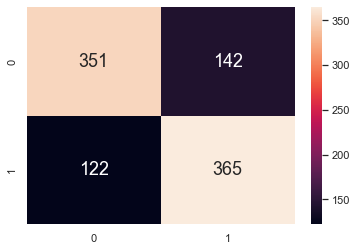

In [ ]:
# Import confusion_matrix from Scikit-Learn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.6857142857142857

TPR Test :	 0.7089201877934272
TNR Test :	 0.6618357487922706

FPR Test :	 0.33816425120772947
FNR Test :	 0.29107981220657275


<AxesSubplot:>

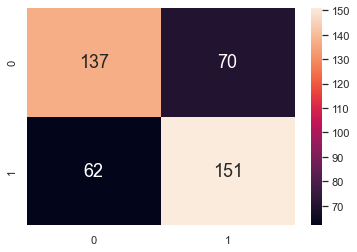

In [ ]:
# Import the required metric from sklearn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Well, it seems that we are not doing too well even with our new model family `RandomForest`. Check it out on Scikit-Learn to see how to improve upon the performance by tuning the paramters -- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html 

It turns out that the two major parameters (actually, called the *hyper-parameters* of this model) of Random Forest are `n_estimators` (the number of decision trees in the forest) and `max_depth` (of each decision tree in the forest). Let's play around a little with the parameters, and see if we can improve.


### Increase the Number of Decision Trees in the Forest

In [ ]:
# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split

# Extract Response and Predictors
y = pd.DataFrame(creditData_ohe_up['Rating'])
X = pd.DataFrame(creditData_ohe_up.drop('Rating', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Import RandomForestClassifier model from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 1000,  # CHANGE AND EXPERIMENT
                                 max_depth = 4)       # CHANGE AND EXPERIMENT

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train.Rating.ravel())

RandomForestClassifier(max_depth=4, n_estimators=1000)

Train Data
Accuracy  :	 0.7346938775510204

TPR Train :	 0.7268993839835729
TNR Train :	 0.742393509127789

FPR Train :	 0.25760649087221094
FNR Train :	 0.2731006160164271


<AxesSubplot:>

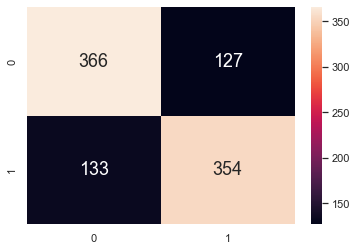

In [ ]:
# Import confusion_matrix from Scikit-Learn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.6904761904761905

TPR Test :	 0.6713615023474179
TNR Test :	 0.7101449275362319

FPR Test :	 0.2898550724637681
FNR Test :	 0.3286384976525822


<AxesSubplot:>

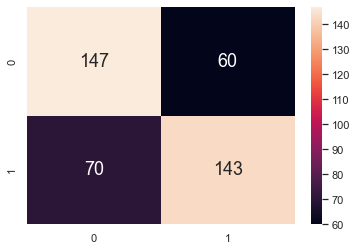

In [ ]:
# Import the required metric from sklearn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

### Increase the Depth of Decision Trees in the Forest

In [ ]:
# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split

# Extract Response and Predictors
y = pd.DataFrame(creditData_ohe_up['Rating'])
X = pd.DataFrame(creditData_ohe_up.drop('Rating', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Import RandomForestClassifier model from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 100,  # CHANGE AND EXPERIMENT
                                 max_depth = 10)       # CHANGE AND EXPERIMENT

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train.Rating.ravel())

RandomForestClassifier(max_depth=10)

Train Data
Accuracy  :	 0.9540816326530612

TPR Train :	 0.9631901840490797
TNR Train :	 0.945010183299389

FPR Train :	 0.054989816700611
FNR Train :	 0.03680981595092025


<AxesSubplot:>

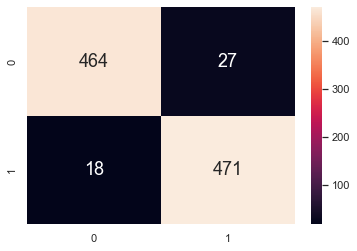

In [ ]:
# Import confusion_matrix from Scikit-Learn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.7642857142857142

TPR Test :	 0.7203791469194313
TNR Test :	 0.8086124401913876

FPR Test :	 0.19138755980861244
FNR Test :	 0.2796208530805687


<AxesSubplot:>

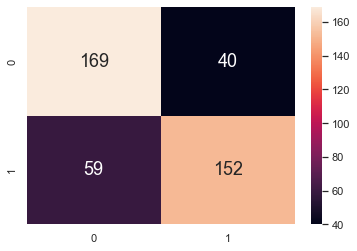

In [ ]:
# Import the required metric from sklearn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

### Increase both Number and Depth of Decision Trees in the Forest

In [ ]:
# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split

# Extract Response and Predictors
y = pd.DataFrame(creditData_ohe_up['Rating'])
X = pd.DataFrame(creditData_ohe_up.drop('Rating', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Import RandomForestClassifier model from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 1000,  # CHANGE AND EXPERIMENT
                                 max_depth = 10)       # CHANGE AND EXPERIMENT

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train.Rating.ravel())

RandomForestClassifier(max_depth=10, n_estimators=1000)

Train Data
Accuracy  :	 0.9520408163265306

TPR Train :	 0.9613034623217923
TNR Train :	 0.9427402862985685

FPR Train :	 0.05725971370143149
FNR Train :	 0.038696537678207736


<AxesSubplot:>

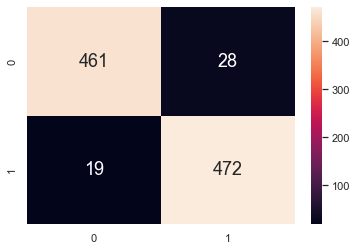

In [ ]:
# Import confusion_matrix from Scikit-Learn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.7785714285714286

TPR Test :	 0.7129186602870813
TNR Test :	 0.8436018957345972

FPR Test :	 0.15639810426540285
FNR Test :	 0.28708133971291866


<AxesSubplot:>

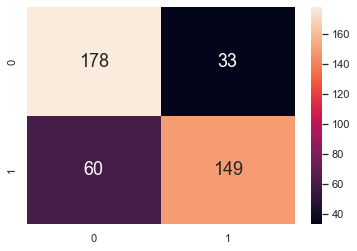

In [ ]:
# Import the required metric from sklearn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Note that with more number of trees and deeper trees in the forest, the accuracy of the Random Forest is getting better on both the train and test sets, but the gap between the performance on train and test is increasing too. This may be an indication of overfitting the train set. Read up more about over-fitting.      

We will need to find the optimal hyper-parameters to maximize accuracy of the classifier on the test set in general. Also note that we are only trying out a single `train_test_split`, and it is impossible to predict the *generalized* performance of the model from a single run. Thus, we will need to run this multiple times, with randomized train and test sets, to get a better estimate. Both of these targets are achieved through Cross-Validation techniques, whereby you can optimize the hyper-parameters of a model. There are several tools available to perform Cross-Validation and Tune Hyper-parameters of a model.

---
## Creating a Model for Rating : Attempt 4

Let's try out a basic set of tools for Cross-Validation, so that we can tune the Hyper-parameters of Random Forest in this case.

In [ ]:
# Import RandomForestClassifier model from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier

# Extract Response and Predictors
y = pd.DataFrame(creditData_ohe_up['Rating'])
X = pd.DataFrame(creditData_ohe_up.drop('Rating', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [ ]:
# Import GridSearch for hyperparameter tuning using Cross-Validation (CV)
from sklearn.model_selection import GridSearchCV

# Define the Hyper-parameter Grid to search on, in case of Random Forest
param_grid = {'n_estimators': np.arange(100,1001,100),   # number of trees 100, 200, ..., 1000
              'max_depth': np.arange(2, 11)}             # depth of trees 2, 3, 4, 5, ..., 10

# Create the Hyper-parameter Grid
hpGrid = GridSearchCV(RandomForestClassifier(),   # the model family
                      param_grid,                 # the search grid
                      cv = 5,                     # 5-fold cross-validation
                      scoring = 'accuracy')       # score to evaluate

# Train the models using Cross-Validation
hpGrid.fit(X_train, y_train.Rating.ravel())

In [ ]:
# Fetch the best Model or the best set of Hyper-parameters
print(hpGrid.best_estimator_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(hpGrid.best_score_))

Note that the Cross-Validation routine is selecting the `best_estimator_` based on the `scoring` parameter of `accuracy`. You may change it to something else, if you want. For instance, `f1` score will be a good `scoring` strategy for binary classification. You may also choose to score your models by their `roc_auc` (Area Under the Receiver Operating Characteristic Curve) metric for a more balanced approach. Read more about these metrics.

F1 Score : https://en.wikipedia.org/wiki/F-score     
ROC-AUC : https://en.wikipedia.org/wiki/Receiver_operating_characteristic

### Use the Best Model found through GridSearchCV

In [ ]:
# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split

# Extract Response and Predictors
y = pd.DataFrame(creditData_ohe_up['Rating'])
X = pd.DataFrame(creditData_ohe_up.drop('Rating', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Import RandomForestClassifier model from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 400,   # found using GridSearchCV
                                 max_depth = 10)       # found using GridSearchCV

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train.Rating.ravel())

In [ ]:
# Import confusion_matrix from Scikit-Learn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

In [ ]:
# Import the required metric from sklearn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Finally, we are done with our model building exercise. Is this complete? Not yet. We have not considered a few other issues that may have resulted in a bad model, like outliers and other imperfections in the dataset. We did not scale the predictors either, or consider other encodings for more ordinal categorical variables like `EmpStatus` and `History`. Thus, what we did today is just about alright as a preliminary model, and there is ample scope for improvement.

**Try exploring the following on your own, at your own time. These may help you in your project!**
* Connecting back the predictions from your model to the EDA you did earlier, and your observations.
* Trying other strategies for encoding of categorical variables to be used in the classification models.
* Trying out other sampling strategies (or something else) for solving the class imabalance problem.
* Trying out `GridSearchCV` with any other model of your choice (DecisionTreeClassifier, if you wish)
* Using Random Forest family of models for Regression instead of Classification (yes, it is possible!)